In [20]:
import pandas as pd
import pickle
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, roc_auc_score, roc_curve, confusion_matrix, ConfusionMatrixDisplay
from sklearn.svm import LinearSVC, SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, ExtraTreesClassifier, AdaBoostClassifier, BaggingClassifier
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
import matplotlib.pyplot as plt
import seaborn as sns
import time

In [2]:
df= pd.read_csv("final_ds.csv")
df.dropna(axis=0, inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 43916 entries, 0 to 43981
Data columns (total 11 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Date            43916 non-null  object 
 1   text            43916 non-null  object 
 2   Hate            43916 non-null  int64  
 3   Time            43916 non-null  object 
 4   Month           43916 non-null  object 
 5   lenText         43916 non-null  int64  
 6   CleanedText     43916 non-null  object 
 7   lenCleanedText  43916 non-null  int64  
 8   TimeCategory    43916 non-null  object 
 9   Hour            43916 non-null  int64  
 10  Sentiment       43916 non-null  float64
dtypes: float64(1), int64(4), object(6)
memory usage: 4.0+ MB


In [3]:
# Splitting and feature extraction
def performTestDataSplitting(x, y, df):
    X_train, X_test, y_train, y_test = train_test_split(df['CleanedText'].dropna(), 
                                                        df['Hate'].dropna(), 
                                                        test_size=x, random_state=y)
    print('Number of rows in the training set:', X_train.shape[0])
    print('Number of rows in the test set:', X_test.shape[0])

    count_vector = CountVectorizer(stop_words='english', lowercase=True)
    training_data = count_vector.fit_transform(X_train.values.astype('U'))
    testing_data = count_vector.transform(X_test.values.astype('U'))
    
    # Save vocabulary
    filename = 'vector_vocabulary.pkl'
    pickle.dump(count_vector.vocabulary_, open(filename, 'wb'))

    return X_train, X_test, y_train, y_test, testing_data, filename, training_data, count_vector

In [4]:
# Splitting data and applying feature extraction
X_train, X_test, y_train, y_test, testing_data, filename, training_data, count_vector = performTestDataSplitting(0.33, 42, df)

Number of rows in the training set: 29423
Number of rows in the test set: 14493


In [5]:
# Model training and evaluation
def pipeline(X_train, y_train, X_test, y_test): 
    learner_list = [
        LinearSVC(), 
        RandomForestClassifier(), 
        LogisticRegression(), 
        KNeighborsClassifier(),
        MultinomialNB(),
        GradientBoostingClassifier(),
        DecisionTreeClassifier(),
        ExtraTreesClassifier(),
        SVC(kernel='rbf', probability=True),
        XGBClassifier(use_label_encoder=False, eval_metric='logloss'),
        AdaBoostClassifier(),
        BaggingClassifier(),
        SGDClassifier()
    ]
    
    results = []
    for learner in learner_list:
        result = {'Algorithm': learner.__class__.__name__}
        print("Training", learner.__class__.__name__)
        
        start = time.time()
        learner.fit(X_train, y_train)
        end = time.time()
        result['Training Time'] = end - start
        
        start = time.time()
        predictions_test = learner.predict(X_test)
        end = time.time()
        result['Prediction Time'] = end - start

        result['Accuracy: Test'] = accuracy_score(y_test, predictions_test)
        result['F1 Score: Test'] = f1_score(y_test, predictions_test)
        result['Precision: Test'] = precision_score(y_test, predictions_test)
        result['Recall: Test'] = recall_score(y_test, predictions_test)

        results.append(result)
        
        # Save each model
        model_filename = learner.__class__.__name__ + ".pkl"
        pickle.dump(learner, open(model_filename, 'wb'))

    return pd.DataFrame(results)

In [6]:
# Get model results
results = pipeline(training_data, y_train, testing_data, y_test)

Training LinearSVC


c:\Users\MIHIR_KOSREKAR\anaconda3\Lib\site-packages\sklearn\svm\_classes.py:31: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
c:\Users\MIHIR_KOSREKAR\anaconda3\Lib\site-packages\sklearn\svm\_base.py:1237: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Training RandomForestClassifier
Training LogisticRegression


c:\Users\MIHIR_KOSREKAR\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training KNeighborsClassifier
Training MultinomialNB
Training GradientBoostingClassifier
Training DecisionTreeClassifier
Training ExtraTreesClassifier
Training SVC
Training XGBClassifier


c:\Users\MIHIR_KOSREKAR\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [10:23:46] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Training AdaBoostClassifier


c:\Users\MIHIR_KOSREKAR\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Training BaggingClassifier
Training SGDClassifier


In [7]:
def performFinalResults(final_results):
  results = pd.DataFrame(final_results)
  results = results.reindex(columns = ['Algorithm', 'Accuracy: Test', 'Precision: Test', 'Recall: Test', 'F1 Score: Test', 'Prediction Time',
                          'Accuracy: Train', 'Precision: Train', 'Recall: Train', 'F1 Score: Train', 'Training Time'])

  results.sort_values(by = 'F1 Score: Test', inplace = True, ascending = False)

  return results

In [8]:
results=performFinalResults(results)
results.reset_index(drop = True)

,Algorithm,Accuracy: Test,Precision: Test,Recall: Test,F1 Score: Test,Prediction Time,Accuracy: Train,Precision: Train,Recall: Train,F1 Score: Train,Training Time
0,RandomForestClassifier,0.957566,0.973576,0.960367,0.966927,1.997363,NaN,NaN,NaN,NaN,181.196882
1,DecisionTreeClassifier,0.957290,0.971521,0.962077,0.966776,0.015460,NaN,NaN,NaN,NaN,13.952761
2,BaggingClassifier,0.955772,0.972168,0.958979,0.965528,0.134694,NaN,NaN,NaN,NaN,934.487768
3,LinearSVC,0.952460,0.967947,0.958124,0.963011,0.003503,NaN,NaN,NaN,NaN,4.682419
4,LogisticRegression,0.942662,0.956052,0.955133,0.955592,0.003000,NaN,NaN,NaN,NaN,1.534044
5,SGDClassifier,0.938384,0.958225,0.945839,0.951992,0.002001,NaN,NaN,NaN,NaN,0.239635
6,ExtraTreesClassifier,0.934382,0.958761,0.938789,0.948670,4.992067,NaN,NaN,NaN,NaN,252.218837
7,MultinomialNB,0.890982,0.921917,0.908129,0.914971,0.007670,NaN,NaN,NaN,NaN,0.062669
8,XGBClassifier,0.887325,0.941499,0.880248,0.909844,0.061025,NaN,NaN,NaN,NaN,3.737203
9,KNeighborsClassifier,0.844132,0.855740,0.912509,0.883214,32.110846,NaN,NaN,NaN,NaN,0.012177


In [9]:
results.describe().loc[['min', 'max'], :]

,Accuracy: Test,Precision: Test,Recall: Test,F1 Score: Test,Prediction Time,Accuracy: Train,Precision: Train,Recall: Train,F1 Score: Train,Training Time
min,0.784103,0.759710,0.732828,0.826556,0.002001,NaN,NaN,NaN,NaN,0.012177
max,0.957566,0.973576,0.973721,0.966927,57.671830,NaN,NaN,NaN,NaN,934.487768


In [10]:
# Visualize results
def plot_results(results):
    sns.set_style('darkgrid')
    plt.figure(figsize=(10, 7))
    
    barWidth = 0.2
    r1 = np.arange(len(results['Algorithm']))
    plt.bar(r1, results['Accuracy: Test'], color='blue', width=barWidth, label='Test Accuracy')
    plt.bar(r1 + barWidth, results['F1 Score: Test'], color='orange', width=barWidth, label='F1 Score')
    
    plt.xlabel('Algorithm')
    plt.ylabel('Score')
    plt.xticks(r1 + barWidth / 2, results['Algorithm'], rotation=90)
    plt.legend()
    plt.title('Classification Summary of Algorithms')
    plt.show()

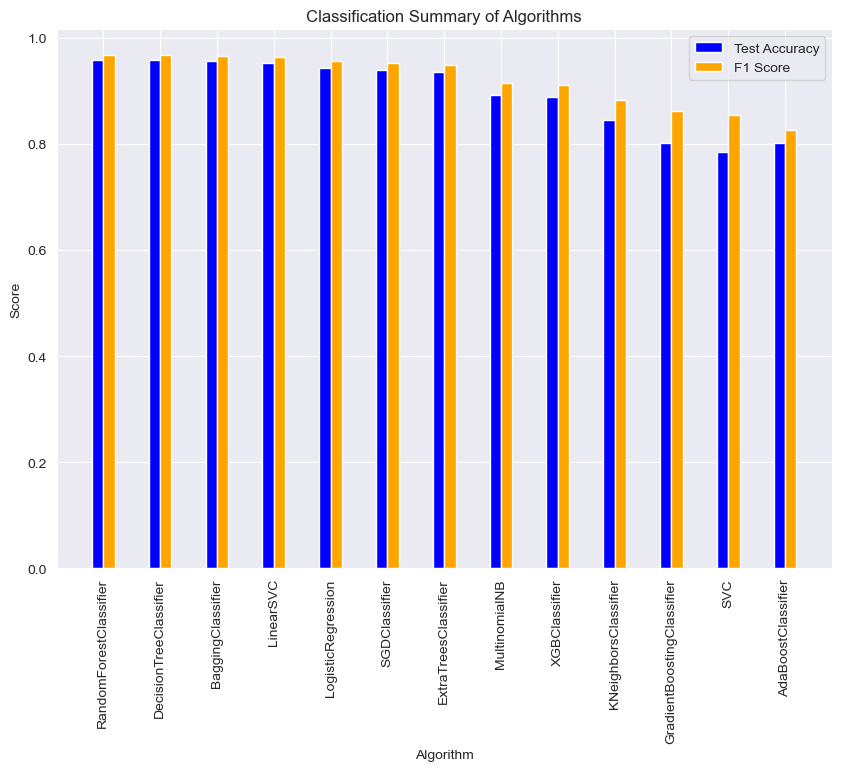

In [11]:
plot_results(results)

In [12]:
def plot_auc_roc(models, X_test, y_test):
    plt.figure(figsize=(12, 8))
    
    for model_name in models:
        model = pickle.load(open(model_name + ".pkl", 'rb'))
        
        # Check if the model supports predict_proba (needed for AUC-ROC calculation)
        if hasattr(model, "predict_proba"):
            probabilities = model.predict_proba(X_test)[:, 1]
            auc_score = roc_auc_score(y_test, probabilities)
            fpr, tpr, _ = roc_curve(y_test, probabilities)
            plt.plot(fpr, tpr, label=f'{model_name} (AUC = {auc_score:.2f})')
            
        # If the model does not support predict_proba, check for decision_function as an alternative
        elif hasattr(model, "decision_function"):
            decision_function = model.decision_function(X_test)
            auc_score = roc_auc_score(y_test, decision_function)
            fpr, tpr, _ = roc_curve(y_test, decision_function)
            plt.plot(fpr, tpr, label=f'{model_name} (AUC = {auc_score:.2f})')

    plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curves for All Models')
    plt.legend(loc='lower right')
    plt.show()


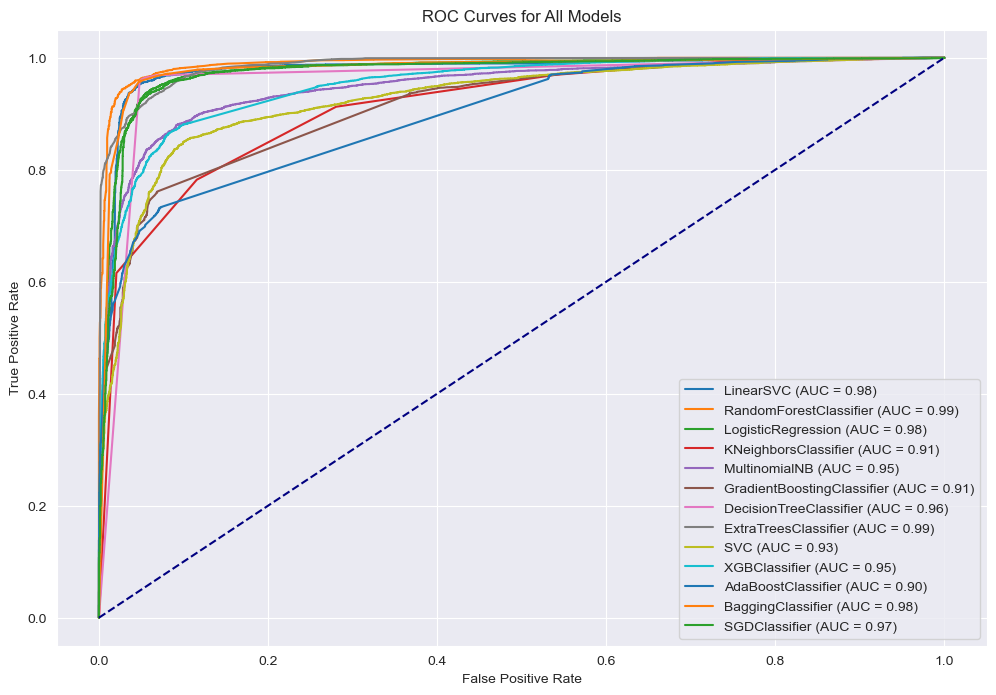

In [13]:
# List of model names to load and evaluate
model_names = [
    'LinearSVC', 'RandomForestClassifier', 'LogisticRegression', 'KNeighborsClassifier', 
    'MultinomialNB', 'GradientBoostingClassifier', 'DecisionTreeClassifier', 
    'ExtraTreesClassifier', 'SVC', 'XGBClassifier', 'AdaBoostClassifier', 
    'BaggingClassifier', 'SGDClassifier'
]

# Call the function with the testing data
plot_auc_roc(model_names, testing_data, y_test)

In [27]:
def plot_confusion_matrices(models, X_test, y_test):
    plt.figure(figsize=(15, 15))
    
    for i, model_name in enumerate(models):
        model = pickle.load(open(model_name + ".pkl", 'rb'))
        predictions = model.predict(X_test)

        # Compute confusion matrix
        cm = confusion_matrix(y_test, predictions)
        
        # Create a subplot for each confusion matrix
        plt.subplot(4, 4, i + 1)
        
        # Create a heatmap for the confusion matrix
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, 
                    xticklabels=['non-bullying', 'bullying'], 
                    yticklabels=['non-bullying', 'bullying'])
        
        plt.title(model_name)
        plt.xlabel('Predicted')
        plt.ylabel('Actual')
    
    plt.tight_layout()
    plt.show()

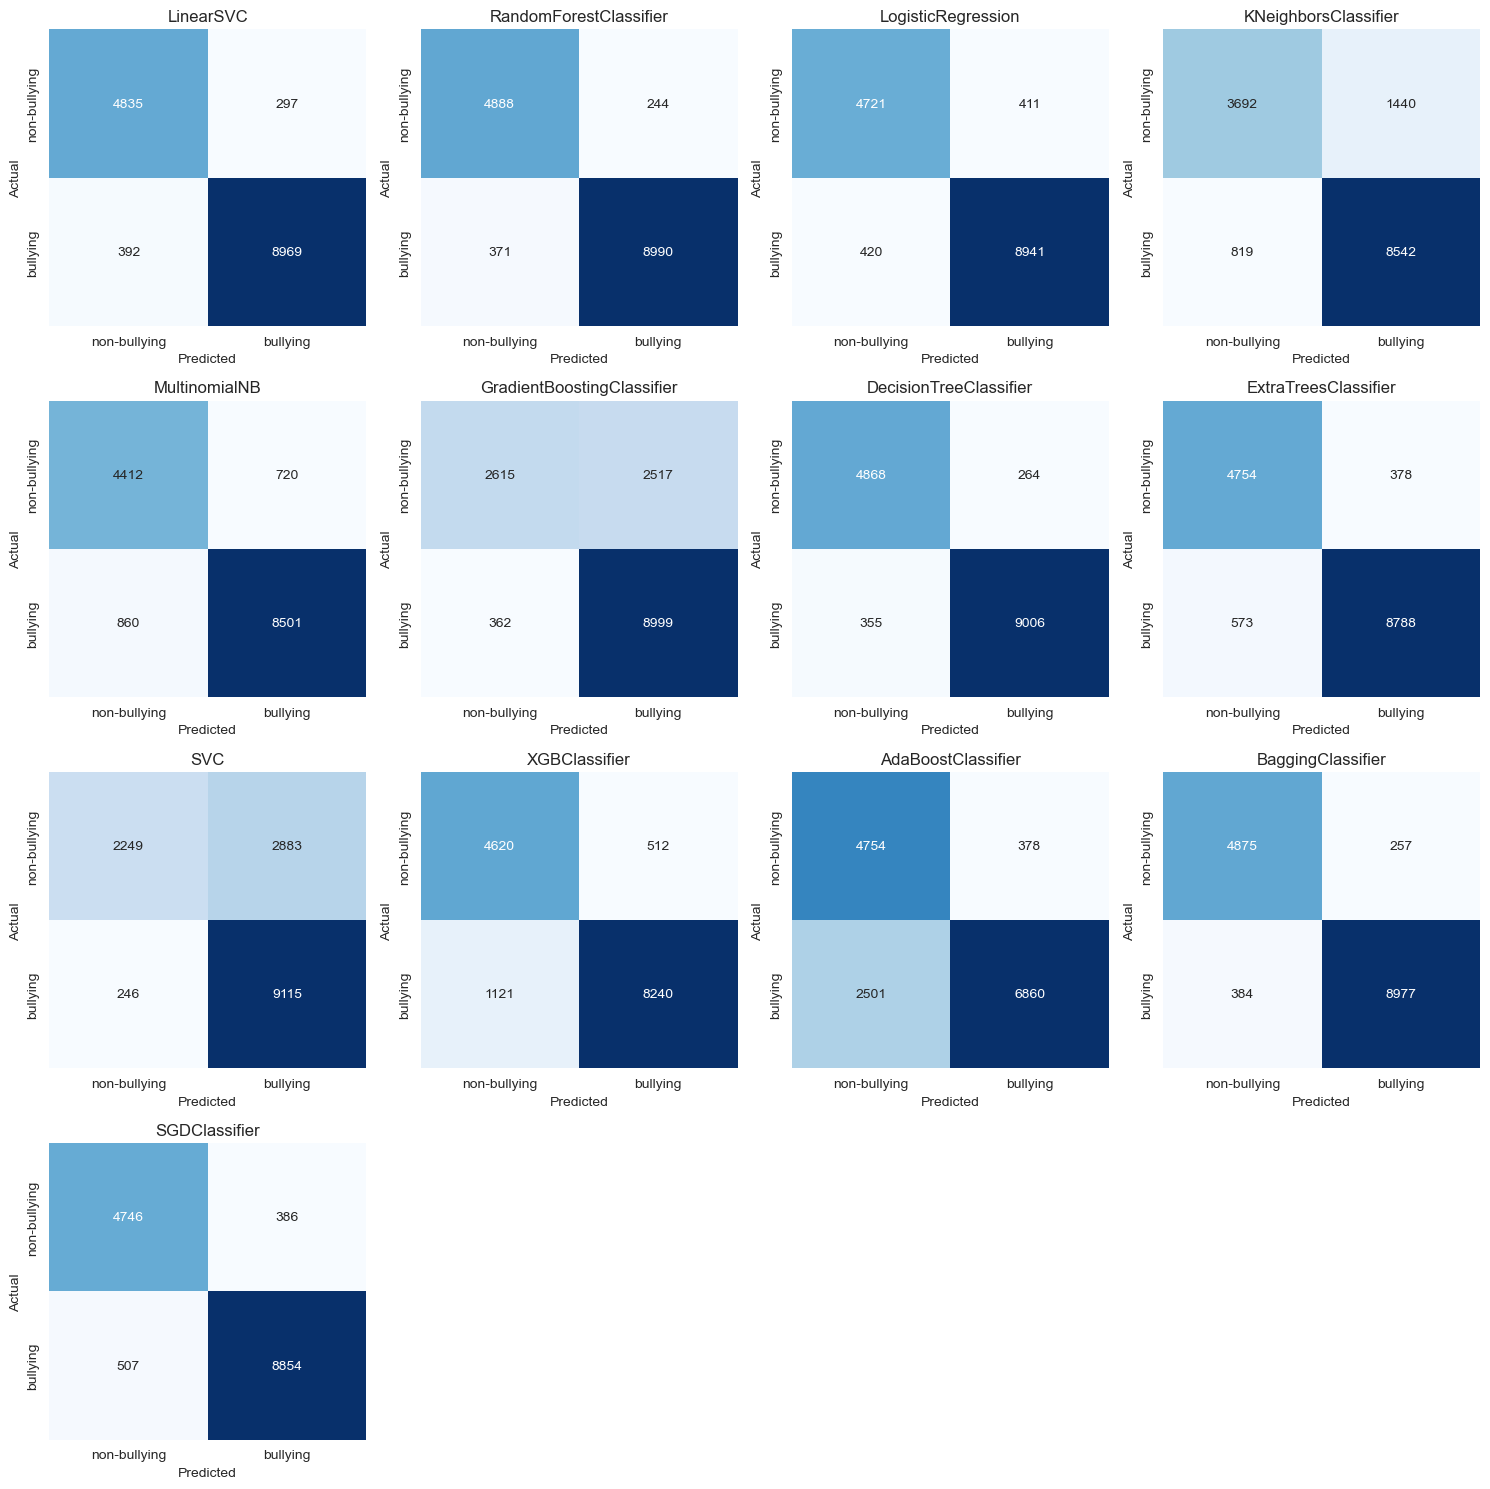

In [28]:
# Call the function with the testing data
plot_confusion_matrices(model_names, testing_data, y_test)

Text(0.5, 1.0, 'Training and Prediction time of Algorithms')

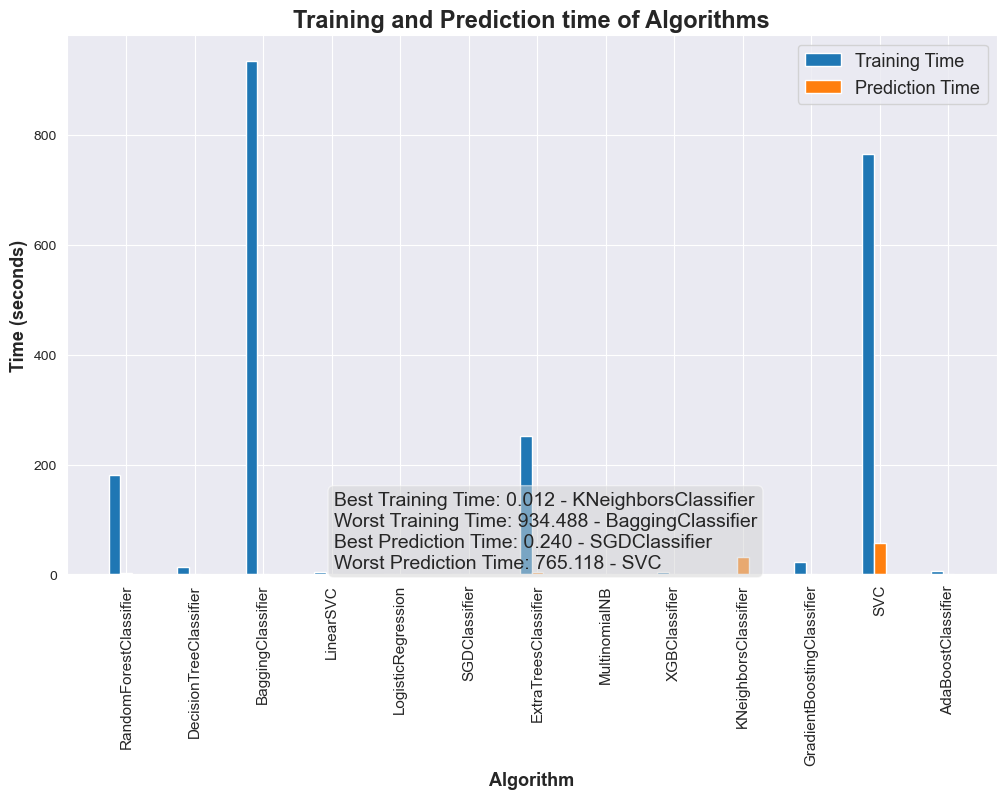

In [14]:
# store the best/worst performance time
best_train_time = results[results['Training Time'] == results['Training Time'].min()]
worst_train_time = results[results['Training Time'] == results['Training Time'].max()]
best_prediction_time = results[results['Prediction Time'] == results['Prediction Time'].min()]
worst_prediction_time = results[results['Prediction Time'] == results['Prediction Time'].max()]

plt.figure(figsize = (12, 7))

barWidth = 0.17
 
# set height of bar
bars1 = results['Training Time']
bars2 = results['Prediction Time']
 
# Set position of bar on X axis
r1 = np.arange(len(bars1))
r2 = [x + barWidth for x in r1]
 
# Make the plot
pal = sns.color_palette()
plt.bar(r1, bars1, color= pal[0], width=barWidth, edgecolor='white', label='Training Time')
plt.bar(r2, bars2, color= pal[1], width=barWidth, edgecolor='white', label='Prediction Time')
 
# Add xticks on the middle of the group bars
plt.xlabel('Algorithm', fontweight='bold', fontsize = 13)
plt.ylabel('Time (seconds)', fontweight = 'bold', fontsize = 13)
plt.xticks([r + barWidth for r in range(len(bars1))], results['Algorithm'], rotation = 90, fontsize = 11)


textstr = '\n'.join(('Best Training Time: {:.3f} - {}'.format(best_train_time['Training Time'].values[0], best_train_time['Algorithm'].values[0]), 
                     'Worst Training Time: {:.3f} - {}'.format(worst_train_time['Training Time'].values[0], worst_train_time['Algorithm'].values[0]),
                   'Best Prediction Time: {:.3f} - {}'.format(best_prediction_time['Training Time'].values[0], best_prediction_time['Algorithm'].values[0]), 
                    'Worst Prediction Time: {:.3f} - {}'.format(worst_prediction_time['Training Time'].values[0], worst_prediction_time['Algorithm'].values[0])))
props = dict(boxstyle='round', facecolor='lightgrey', alpha=0.5)

#place a text box
plt.text(3.2, 12, textstr, fontsize=14,  bbox=props) 

# Create legend & Show graphic
plt.legend(fontsize = 13)
plt.title('Training and Prediction time of Algorithms', fontweight = 'bold', fontsize = 17)

In [15]:
# Testing new data
def test_new_data(text):
    count_vector = CountVectorizer(stop_words='english', lowercase=True, vocabulary=pickle.load(open("vector_vocabulary.pkl", "rb")))
    data = count_vector.transform([text])

    for model_name in ['LinearSVC', 'RandomForestClassifier', 'LogisticRegression', 'KNeighborsClassifier', 
                       'MultinomialNB', 'GradientBoostingClassifier', 'DecisionTreeClassifier', 
                       'ExtraTreesClassifier', 'SVC', 'XGBClassifier',
                       'AdaBoostClassifier', 'BaggingClassifier', 'SGDClassifier']:
        model = pickle.load(open(model_name + ".pkl", 'rb'))
        
        prediction = model.predict(data)
        print(f"\n{model_name} Prediction:", "bullying" if prediction == 1 else "non-bullying")
        
        if hasattr(model, "predict_proba"):
            probabilities = model.predict_proba(data)
            print(f"Probability:", max(probabilities[0]))

In [16]:
test_new_data("Are you a bitch?")


LinearSVC Prediction: bullying

RandomForestClassifier Prediction: bullying
Probability: 0.919988582925502

LogisticRegression Prediction: bullying
Probability: 0.9328475862108289

KNeighborsClassifier Prediction: bullying
Probability: 1.0

MultinomialNB Prediction: bullying
Probability: 0.9877186886632224

GradientBoostingClassifier Prediction: bullying
Probability: 0.8055971821475472

DecisionTreeClassifier Prediction: bullying
Probability: 0.9090909090909091

ExtraTreesClassifier Prediction: bullying
Probability: 0.9090909090909075

SVC Prediction: bullying
Probability: 0.8732046132787233

XGBClassifier Prediction: bullying
Probability: 0.90277433

AdaBoostClassifier Prediction: bullying
Probability: 0.5108576909208054

BaggingClassifier Prediction: bullying
Probability: 0.9396638655462185

SGDClassifier Prediction: bullying


In [17]:
test_new_data("Are you a switch?")


LinearSVC Prediction: bullying

RandomForestClassifier Prediction: non-bullying
Probability: 0.5599641330891333

LogisticRegression Prediction: non-bullying
Probability: 0.5193898494154643

KNeighborsClassifier Prediction: bullying
Probability: 0.6

MultinomialNB Prediction: bullying
Probability: 0.6112749474849986

GradientBoostingClassifier Prediction: bullying
Probability: 0.5614116880083693

DecisionTreeClassifier Prediction: non-bullying
Probability: 0.5454545454545454

ExtraTreesClassifier Prediction: non-bullying
Probability: 0.5545454545454553

SVC Prediction: bullying
Probability: 0.6731549649917664

XGBClassifier Prediction: non-bullying
Probability: 0.5298378

AdaBoostClassifier Prediction: non-bullying
Probability: 0.5005375861301735

BaggingClassifier Prediction: non-bullying
Probability: 0.5360989010989011

SGDClassifier Prediction: non-bullying


In [18]:
test_new_data("You are a talking person")


LinearSVC Prediction: non-bullying

RandomForestClassifier Prediction: non-bullying
Probability: 0.5944707514707516

LogisticRegression Prediction: non-bullying
Probability: 0.6625848182889646

KNeighborsClassifier Prediction: bullying
Probability: 0.6

MultinomialNB Prediction: bullying
Probability: 0.6614089145833115

GradientBoostingClassifier Prediction: bullying
Probability: 0.5614116880083693

DecisionTreeClassifier Prediction: non-bullying
Probability: 1.0

ExtraTreesClassifier Prediction: non-bullying
Probability: 0.96

SVC Prediction: bullying
Probability: 0.6466685730426746

XGBClassifier Prediction: non-bullying
Probability: 0.5298378

AdaBoostClassifier Prediction: non-bullying
Probability: 0.5005375861301735

BaggingClassifier Prediction: non-bullying
Probability: 0.8625

SGDClassifier Prediction: non-bullying


In [19]:
test_new_data("You are a fucking person")


LinearSVC Prediction: non-bullying

RandomForestClassifier Prediction: bullying
Probability: 0.627026418026418

LogisticRegression Prediction: non-bullying
Probability: 0.6859321348695177

KNeighborsClassifier Prediction: bullying
Probability: 0.6

MultinomialNB Prediction: bullying
Probability: 0.8631453382941593

GradientBoostingClassifier Prediction: bullying
Probability: 0.5614116880083693

DecisionTreeClassifier Prediction: non-bullying
Probability: 1.0

ExtraTreesClassifier Prediction: bullying
Probability: 0.7545454545454545

SVC Prediction: bullying
Probability: 0.6848096963943268

XGBClassifier Prediction: bullying
Probability: 0.5374269

AdaBoostClassifier Prediction: non-bullying
Probability: 0.5005375861301735

BaggingClassifier Prediction: non-bullying
Probability: 1.0

SGDClassifier Prediction: non-bullying
